# DNN - NSL

In [1]:
cd C:\\Users\\Sharuka Thirimanne\\Desktop\\FYP-ML-IDS

C:\Users\Sharuka Thirimanne\Desktop\FYP-ML-IDS


In [2]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from sklearn.decomposition import PCA
from tensorflow.keras import regularizers
from tensorflow.keras import Model, layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report,confusion_matrix


c:\users\sharuka thirimanne\appdata\local\programs\python\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\sharuka thirimanne\appdata\local\programs\python\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\sharuka thirimanne\appdata\local\programs\python\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
def load_train_dataset():
    df_train = pd.read_csv('NSL_train-set.csv')
    
    limit = df_train.shape[1]-1
    
    X_train = df_train.iloc[:,0:limit]
    Y_train = df_train.iloc[:,limit]
    
    return X_train, Y_train, df_train

X_train, Y_train, df_train = load_train_dataset()

In [5]:
def load_test_dataset():
    df_test = pd.read_csv('NSL_test-set.csv')

    limit = df_test.shape[1]-1
    
    X_test = df_test.iloc[:,0:limit]
    Y_test = df_test.iloc[:,limit]
    
    return X_test, Y_test, df_test

X_test, Y_test, df_test = load_test_dataset()

In [6]:
X_train, X_val , Y_train , Y_val = train_test_split(X_train,Y_train, test_size=0.065,stratify = Y_train,shuffle=True,random_state=42)

print('Training X   :',X_train.shape)
print('Validation X :',X_val.shape)
print('Test_X       :',X_test.shape)
print('Training_Y   :',Y_train.shape)
print('Validation Y :',Y_val.shape)
print('Test_Y       :',Y_test.shape)

Training X   : (99854, 62)
Validation X : (6942, 62)
Test_X       : (22310, 62)
Training_Y   : (99854,)
Validation Y : (6942,)
Test_Y       : (22310,)


In [7]:
METRICS = [ 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

In [9]:
def neural_network():
    #Neural Network Model
    model = Sequential()
    model.add(Dense(128, input_dim=62, activation='relu',kernel_initializer='glorot_uniform',
                    bias_initializer='zeros',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='SGD', metrics = METRICS)
    
    return model


In [10]:
estimator = KerasClassifier(build_fn=neural_network)
estimator.fit(X_train,Y_train,verbose=1,callbacks=[early_stopping], epochs=200,validation_data=(X_val,Y_val), batch_size=128)


Train on 99854 samples, validate on 6942 samples
Epoch 1/200
99854/99854 [==============================] - 3s 28us/step - loss: 5.4672 - accuracy: 0.8642 - precision: 0.9773 - recall: 0.7441 - auc: 0.9290 - val_loss: 4.5688 - val_accuracy: 0.9239 - val_precision: 0.9762 - val_recall: 0.8690 - val_auc: 0.9681
Epoch 2/200
99854/99854 [==============================] - 2s 25us/step - loss: 3.9419 - accuracy: 0.9372 - precision: 0.9761 - recall: 0.8963 - auc: 0.9747 - val_loss: 3.3843 - val_accuracy: 0.9458 - val_precision: 0.9770 - val_recall: 0.9131 - val_auc: 0.9792
Epoch 3/200
99854/99854 [==============================] - 2s 25us/step - loss: 2.9297 - accuracy: 0.9504 - precision: 0.9782 - recall: 0.9215 - auc: 0.9817 - val_loss: 2.5247 - val_accuracy: 0.9539 - val_precision: 0.9793 - val_recall: 0.9275 - val_auc: 0.9838
Epoch 4/200
99854/99854 [==============================] - 3s 27us/step - loss: 2.1922 - accuracy: 0.9562 - precision: 0.9800 - recall: 0.9315 - auc: 0.9852 - val_lo

Epoch 32/200
99854/99854 [==============================] - 4s 37us/step - loss: 0.1521 - accuracy: 0.9714 - precision: 0.9863 - recall: 0.9560 - auc: 0.9948 - val_loss: 0.1553 - val_accuracy: 0.9714 - val_precision: 0.9863 - val_recall: 0.9561 - val_auc: 0.9948
Epoch 33/200
99854/99854 [==============================] - 3s 32us/step - loss: 0.1515 - accuracy: 0.9715 - precision: 0.9864 - recall: 0.9562 - auc: 0.9949 - val_loss: 0.1540 - val_accuracy: 0.9715 - val_precision: 0.9864 - val_recall: 0.9563 - val_auc: 0.9949
Epoch 34/200
99854/99854 [==============================] - 3s 34us/step - loss: 0.1510 - accuracy: 0.9716 - precision: 0.9864 - recall: 0.9564 - auc: 0.9949 - val_loss: 0.1543 - val_accuracy: 0.9716 - val_precision: 0.9864 - val_recall: 0.9564 - val_auc: 0.9949
Epoch 35/200
99854/99854 [==============================] - 3s 32us/step - loss: 0.1505 - accuracy: 0.9717 - precision: 0.9864 - recall: 0.9565 - auc: 0.9950 - val_loss: 0.1531 - val_accuracy: 0.9717 - val_preci

99854/99854 [==============================] - 3s 26us/step - loss: 0.1374 - accuracy: 0.9750 - precision: 0.9877 - recall: 0.9619 - auc: 0.9962 - val_loss: 0.1407 - val_accuracy: 0.9750 - val_precision: 0.9877 - val_recall: 0.9619 - val_auc: 0.9962
Epoch 95/200
99854/99854 [==============================] - 3s 27us/step - loss: 0.1375 - accuracy: 0.9750 - precision: 0.9877 - recall: 0.9620 - auc: 0.9962 - val_loss: 0.1430 - val_accuracy: 0.9750 - val_precision: 0.9877 - val_recall: 0.9620 - val_auc: 0.9962
Epoch 96/200
99854/99854 [==============================] - 3s 28us/step - loss: 0.1373 - accuracy: 0.9750 - precision: 0.9877 - recall: 0.9620 - auc: 0.9962 - val_loss: 0.1404 - val_accuracy: 0.9750 - val_precision: 0.9877 - val_recall: 0.9620 - val_auc: 0.9962
Epoch 97/200
99854/99854 [==============================] - 3s 28us/step - loss: 0.1372 - accuracy: 0.9750 - precision: 0.9877 - recall: 0.9620 - auc: 0.9962 - val_loss: 0.1391 - val_accuracy: 0.9751 - val_precision: 0.9877 

Epoch 156/200
99854/99854 [==============================] - 3s 25us/step - loss: 0.1312 - accuracy: 0.9764 - precision: 0.9883 - recall: 0.9642 - auc: 0.9966 - val_loss: 0.1446 - val_accuracy: 0.9764 - val_precision: 0.9883 - val_recall: 0.9643 - val_auc: 0.9966
Epoch 157/200
99854/99854 [==============================] - 3s 26us/step - loss: 0.1313 - accuracy: 0.9764 - precision: 0.9883 - recall: 0.9643 - auc: 0.9966 - val_loss: 0.1338 - val_accuracy: 0.9764 - val_precision: 0.9883 - val_recall: 0.9643 - val_auc: 0.9966
Epoch 158/200
99854/99854 [==============================] - 3s 25us/step - loss: 0.1311 - accuracy: 0.9764 - precision: 0.9883 - recall: 0.9643 - auc: 0.9966 - val_loss: 0.1338 - val_accuracy: 0.9764 - val_precision: 0.9883 - val_recall: 0.9643 - val_auc: 0.9967
Epoch 159/200
99854/99854 [==============================] - 3s 25us/step - loss: 0.1310 - accuracy: 0.9764 - precision: 0.9883 - recall: 0.9643 - auc: 0.9966 - val_loss: 0.1564 - val_accuracy: 0.9765 - val_p

99854/99854 [==============================] - 3s 25us/step - loss: 0.1291 - accuracy: 0.9769 - precision: 0.9885 - recall: 0.9650 - auc: 0.9968 - val_loss: 0.1407 - val_accuracy: 0.9769 - val_precision: 0.9885 - val_recall: 0.9651 - val_auc: 0.9968
Epoch 188/200
99854/99854 [==============================] - 3s 26us/step - loss: 0.1291 - accuracy: 0.9769 - precision: 0.9885 - recall: 0.9651 - auc: 0.9968 - val_loss: 0.1331 - val_accuracy: 0.9769 - val_precision: 0.9885 - val_recall: 0.9651 - val_auc: 0.9968
Epoch 189/200
99854/99854 [==============================] - 3s 26us/step - loss: 0.1291 - accuracy: 0.9769 - precision: 0.9885 - recall: 0.9651 - auc: 0.9968 - val_loss: 0.1330 - val_accuracy: 0.9769 - val_precision: 0.9885 - val_recall: 0.9651 - val_auc: 0.9968
Epoch 190/200
99854/99854 [==============================] - 2s 25us/step - loss: 0.1289 - accuracy: 0.9769 - precision: 0.9885 - recall: 0.9651 - auc: 0.9968 - val_loss: 0.1327 - val_accuracy: 0.9769 - val_precision: 0.98

In [11]:
print("Cross-Validation set accuracy: {:.6f} %".format((cross_val_score(estimator, X_val, Y_val, 
                                                                        cv=3,scoring='accuracy').mean())*100))
test_predictions = estimator.predict(X_test)
print("Train set accuracy           : {:.4f} %".format(estimator.score(X_train,Y_train)*100))
print("Test set accuracy            : {:.4f} %".format(accuracy_score(Y_test, test_predictions)*100))
print("Test set precision           : {:.4f} %".format(precision_score(Y_test, test_predictions)*100))
print("Test set recall              : {:.4f} %".format(recall_score(Y_test, test_predictions)*100))

Epoch 1/1
4628/4628 [==============================] - 0s 107us/step - loss: 6.4053 - accuracy: 0.9771 - precision: 0.9885 - recall: 0.9653 - auc: 0.9968
Epoch 1/1
4628/4628 [==============================] - 0s 108us/step - loss: 6.4057 - accuracy: 0.9770 - precision: 0.9885 - recall: 0.9652 - auc: 0.9968
Epoch 1/1
4628/4628 [==============================] - 0s 107us/step - loss: 6.4526 - accuracy: 0.9770 - precision: 0.9885 - recall: 0.9652 - auc: 0.9968
Cross-Validation set accuracy: 89.455488 %
99854/99854 [==============================] - 3s 31us/step
Train set accuracy           : 97.7031 %
Test set accuracy            : 78.6688 %
Test set precision           : 92.3700 %
Test set recall              : 67.8333 %


In [21]:
def plot_metrics(history):
  metrics =  ['accuracy', 'precision', 'recall','auc']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplots(2,2)
    plt.plot(history.epochs,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epochs, history.history['val_'+metric], color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'accuracy':
      plt.ylim([0.8,1])
    elif metric == 'precision':
      plt.ylim([0.8,1])
    elif metric == 'recall':
      plt.ylim([0.8,1])

    plt.legend()

AttributeError: 'KerasClassifier' object has no attribute 'epochs'

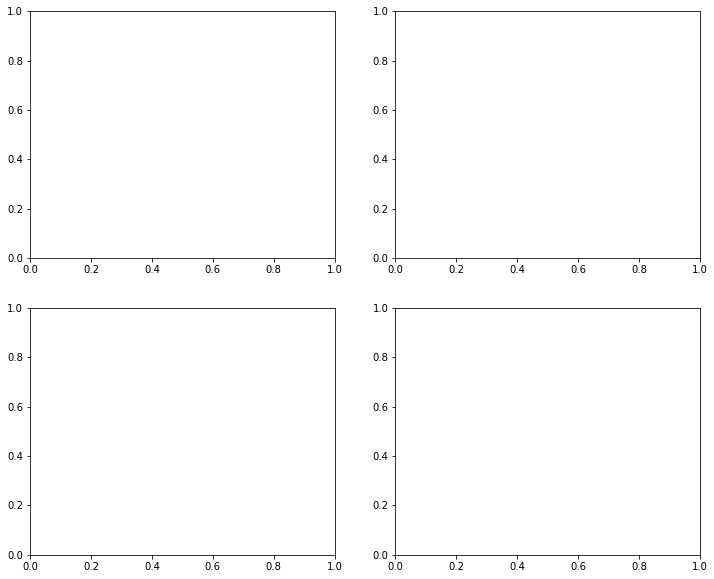

In [22]:
plot_metrics(estimator)

In [23]:
def plot_cm(labels, predictions, p=0.81):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    plt.text(0.3,2.6,'True Negatives  : '+ str(cm[0][0]),size=14)
    plt.text(0.3,2.8,'False Positives   : '+ str(cm[0][1]),size=14)
    plt.text(0.3,3,'False Negatives : '+ str(cm[1][0]),size=14)
    plt.text(0.3,3.2,'True Positives    : '+ str(cm[1][1]),size=14)

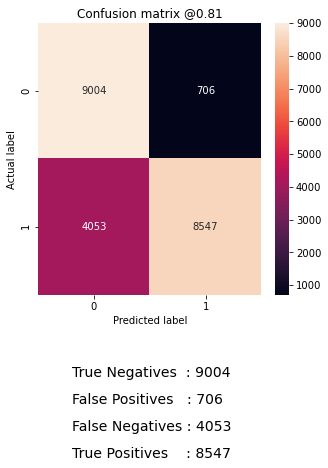

In [24]:
plot_cm(Y_test, test_predictions)

In [25]:
print(classification_report(Y_test, test_predictions.round()))

              precision    recall  f1-score   support

           0       0.69      0.93      0.79      9710
           1       0.92      0.68      0.78     12600

    accuracy                           0.79     22310
   macro avg       0.81      0.80      0.79     22310
weighted avg       0.82      0.79      0.79     22310

